In [5]:
import time

from collections import OrderedDict
from pathlib import Path

import torch
from lib.structures.field_list import collect

from lib import utils, logger, config, modeling, solver, data

import os
import sys

%load_ext autoreload
%autoreload 2

In [6]:
# INPUT_IMG = 'data/front3d-sample/rgb_0007.png'
# OUTPUT_FOLDER = 'output/00/inference'
# CONFIG_FILE = 'configs/front3d_sample.yaml'
# MODEL = 'data/panoptic-front3d.pth'

In [7]:
config.merge_from_file('configs/front3d_train_3d_test.yaml')
model = modeling.PanopticReconstruction()
device = torch.device(config.MODEL.DEVICE)
model.to(device, non_blocking=True)
model.log_model_info()
model.fix_weights()

# Setup optimizer, scheduler, checkpointer
optimizer = torch.optim.Adam(model.parameters(), config.SOLVER.BASE_LR,
                                          betas=(config.SOLVER.BETA_1, config.SOLVER.BETA_2),
                                          weight_decay=config.SOLVER.WEIGHT_DECAY)
scheduler = solver.WarmupMultiStepLR(optimizer, config.SOLVER.STEPS, config.SOLVER.GAMMA,
                                                  warmup_factor=1,
                                                  warmup_iters=0,
                                                  warmup_method="linear")

-----------------------------------------
unet_output_channels 16
unet_fetures 16
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173808


In [8]:
# For Inference
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_64 = 1 # 10000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_128 = 2 # 25000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_256 = 3 #5000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_RGB = 4 #5000  #TO DO: Implement. Right now it is unused

In [9]:
model_dict = model.state_dict()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters: {}".format(pytorch_total_params))

output_path = Path('out')
checkpointer = utils.DetectronCheckpointer(model, optimizer, scheduler, output_path)

# Load the checkpoint
checkpoint_data = checkpointer.load()

checkpoint_arguments = {}
checkpoint_arguments["iteration"] = 0

if config.SOLVER.LOAD_SCHEDULER:
    checkpoint_arguments.update(checkpoint_data)

if config.MODEL.PRETRAIN2D:
    pretrain_2d = torch.load(config.MODEL.PRETRAIN2D)
    model.load_state_dict(pretrain_2d["model"])

# Dataloader
dataloader = data.setup_dataloader(config.DATASETS.TRAIN)

Number of Trainable Parameters: 10367125
Number of Trainable Parameters: 10367125


In [10]:
iteration = 0
iteration_end = time.time()
model.switch_training()

for idx, (image_ids, targets) in enumerate(dataloader):
    assert targets is not None, "error during data loading"
    data_time = time.time() - iteration_end
    # Get input images
    images = collect(targets, "color")

    # Pass through model
    # try:
    losses, results = model(images, targets)
    # except Exception as e:
    #     print(e, "skipping", image_ids[0])
    #     del targets, images
    #     continue

    # Accumulate total loss
    total_loss: torch.Tensor = 0.0
    log_meters = OrderedDict()
    rgb_loss = 0.0
    for loss_group in losses.values():
        for loss_name, loss in loss_group.items():
            if(loss_name == "rgb_total_loss"):
                # print("loss_name: {}, loss: {}".format(loss_name, loss))
                rgb_loss = loss
            if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                total_loss += loss
                log_meters[loss_name] = loss.item()

    # Loss backpropagation, optimizer & scheduler step
    optimizer.zero_grad()

    if torch.is_tensor(total_loss):
        # total_loss.backward()
        # optimizer.step()
        # scheduler.step()
        log_meters["total"] = total_loss.item()
    else:
        log_meters["total"] = total_loss

    # Minkowski Engine recommendation
    torch.cuda.empty_cache()

    # Save checkpoint
    # if iteration % config.SOLVER.CHECKPOINT_PERIOD == 0:
    #     checkpointer.save(f"model_{iteration:07d}", **checkpoint_arguments)

    last_training_stage = model.set_current_training_stage(iteration)

    # Save additional checkpoint after hierarchy level
    if last_training_stage is not None:
        # checkpointer.save(f"model_{last_training_stage}_{iteration:07d}", **checkpoint_arguments)
        logger.info(f"Finish {last_training_stage} hierarchy level")

    print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss), end="")
    if iteration%10 == 0:
        print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss))

    iteration += 1
    iteration_end = time.time()
    if iteration >= 7:
        break

/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:195: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

iteration: 0, total_loss: 0.017317093908786774, rgb_loss:0.0
iteration: 1, total_loss: 0.017016977071762085, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:302: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:329: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 3, total_loss: 0.26029330492019653, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:412: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:509: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 6, total_loss: 255.74728393554688, rgb_loss:83.31292724609375

## Sparse predictions

In [11]:
print(results.keys())
print(results['frustum'].keys())

geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
semantic_sparse_prediction = results['frustum']['semantic3d']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)
print("semantic_sparse shape: ", semantic_sparse_prediction.shape)
aux_views = targets[0].get_field("aux_views").unsqueeze(0)
cam_poses = targets[0].get_field("cam_poses").unsqueeze(0)
# cam_poses[:,:,:,:3,-1] /= 0.0301
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)

dict_keys(['depth', 'instance', 'projection', 'frustum'])
dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])
geometry_sparse shape:  torch.Size([101293, 1])
rgb_sparse shape:  torch.Size([101293, 3])
semantic_sparse shape:  torch.Size([101293, 13])
aux_views shape:  torch.Size([1, 4, 3, 240, 320])
cam_poses shape:  torch.Size([1, 4, 1, 4, 4])


In [12]:
target_sdf = collect(targets, "geometry")
print("target_sdf shape: ", target_sdf.shape)
print("target_sdf range: [{},{}]".format(target_sdf.min(), target_sdf.max()))

target_sdf shape:  torch.Size([1, 1, 256, 256, 256])
target_sdf range: [0.00016082213551271707,3.0]


=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173808


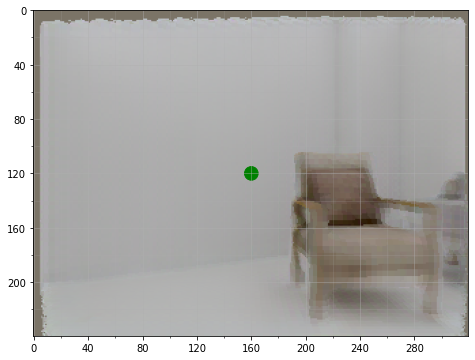

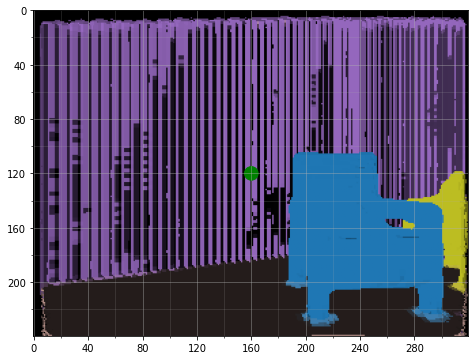

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


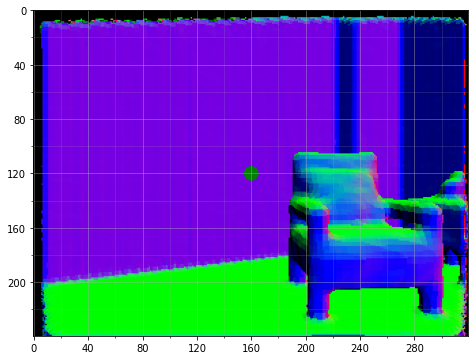

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


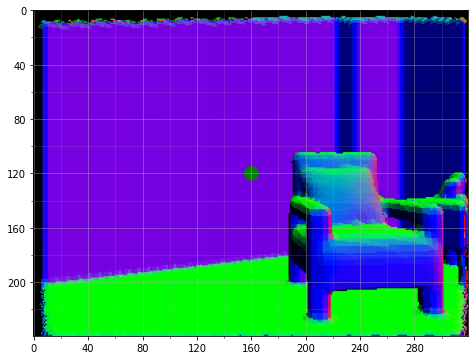

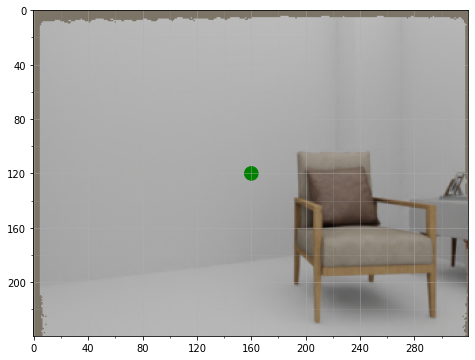

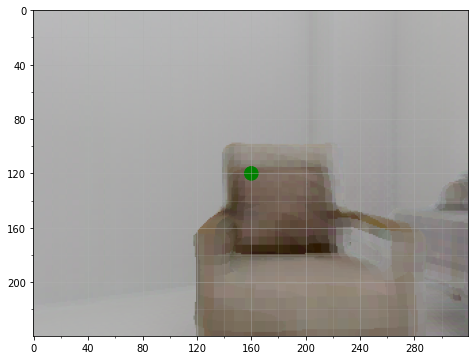

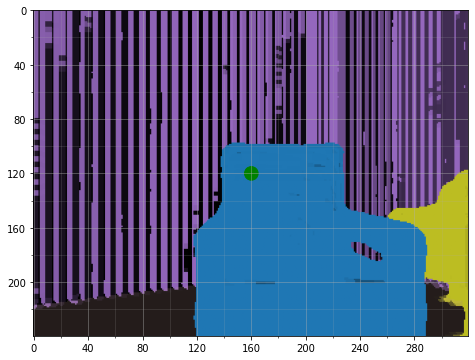

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


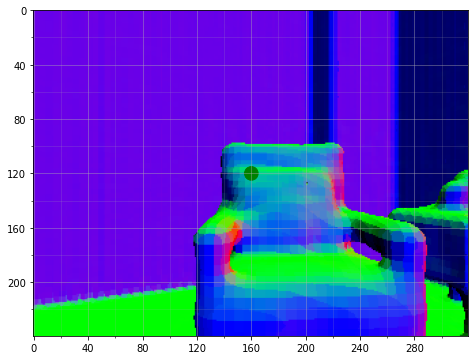

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


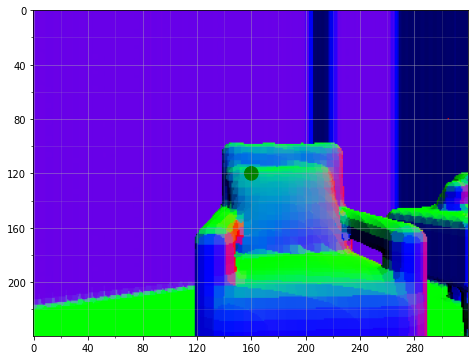

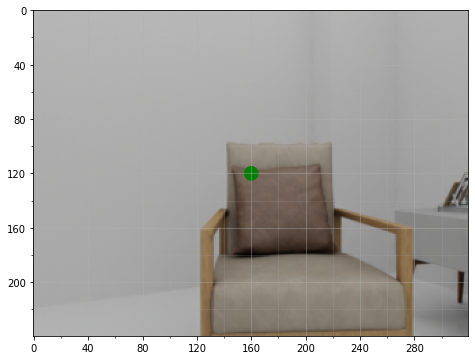

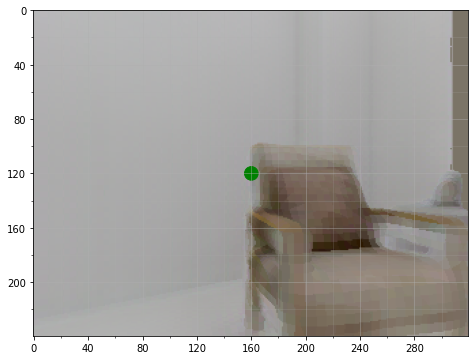

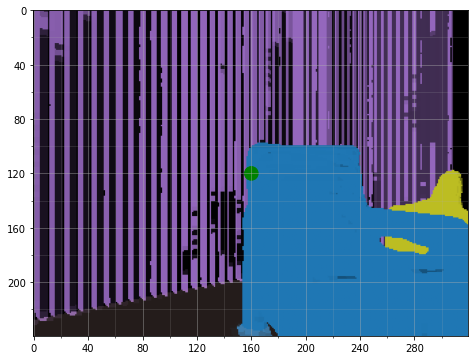

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


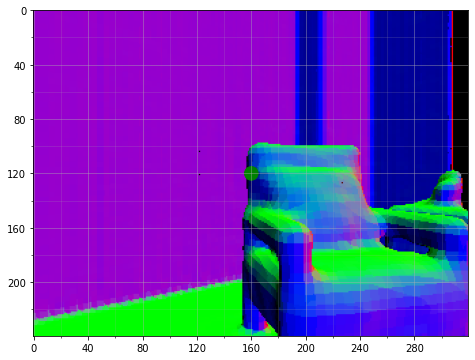

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


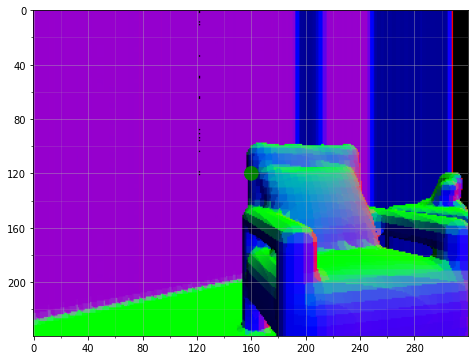

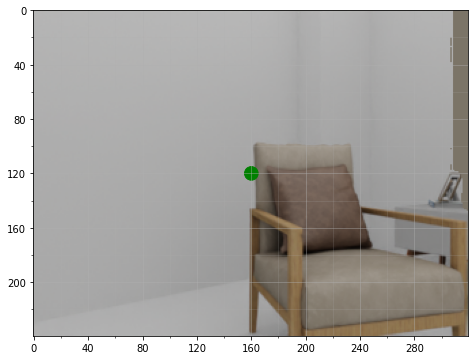

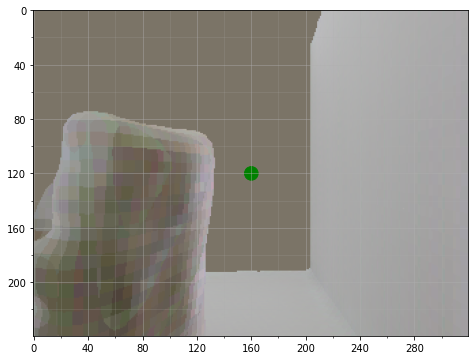

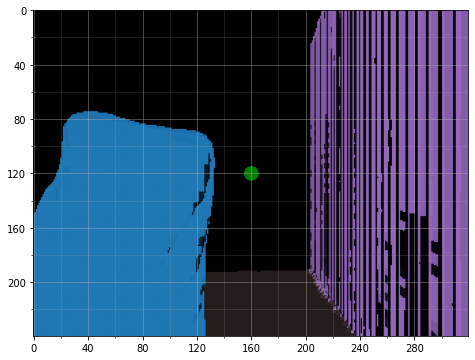

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


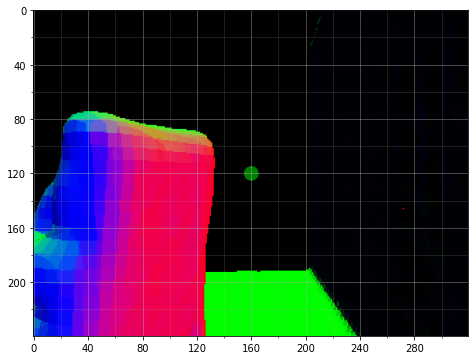

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


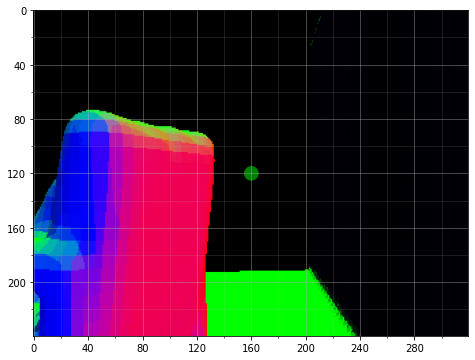

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


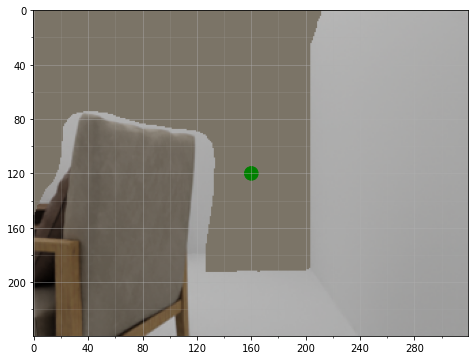

Total loss:  tensor(1.7384, device='cuda:0', grad_fn=<AddBackward0>)
L1 loss:  tensor(0.0825, device='cuda:0', grad_fn=<DivBackward0>)
style loss:  tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)
loss_content:  tensor(165.3249, device='cuda:0', grad_fn=<AddBackward0>)
disc_loss:  tensor(1.3834, device='cuda:0', grad_fn=<AddBackward0>)
gen_loss:  tensor(0.7096, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [13]:
from lib.modeling.frustum.rgb_loss import RGBLoss
from plot_image_grid import plot_image

rgb_loss = RGBLoss()
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, semantic_sparse_prediction, aux_views, cam_poses.to(device), target_sdf, debug=True)

## Render Views

In [10]:
from torch.nn import functional as F

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION
sdf, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)

rgb = rgb.squeeze()
sdf = sdf.squeeze()

# Interpolate to size (254,254,254) to stay inside CUDA's limits
rgb = (F.interpolate(rgb.unsqueeze(0), size=(254,254,254), mode="trilinear", align_corners=True))[0]
sdf = (F.interpolate(sdf.unsqueeze(0).unsqueeze(0), size=(254,254,254), mode="trilinear", align_corners=True))[0,0]

# TODO: Substraction of -1.5 only to have negative values in SDF, but distorts geometry.
sdf -= 1.5
truncation = 1.5

sdf = sdf.unsqueeze(0).unsqueeze(0)
colors = rgb.permute(1,2,3,0).unsqueeze(0)
# Obtain sparse tensor of sdf, colors and semantic weights
locs = torch.nonzero(torch.abs(sdf[:,0]) < truncation)
locs = torch.cat([locs[:,1:], locs[:,:1]],1).contiguous()
vals = sdf[locs[:,-1],:,locs[:,0],locs[:,1],locs[:,2]].contiguous()
colors = colors[locs[:,-1],locs[:,0],locs[:,1],locs[:,2],:].float() #/255.0

# Divide translation vector in cam_poses by the voxel size
cam_poses[:,:,:,:3,-1] /= 0.0301

In [11]:
from utils.raycast_rgbd.raycast_rgbd import RaycastRGBD
from math import sin,cos
def homogeneous_transform(R,t):
    last_row = torch.FloatTensor([[0,0,0,1]]).unsqueeze(0)
    T = torch.cat((R,t),dim=2)
    return torch.cat((T,last_row),dim=1)

def rot_x(t):
    return torch.FloatTensor([[1,0,0],[0,cos(t),-sin(t)],[0,sin(t),cos(t)]])

def rot_y(t):
    return torch.FloatTensor([[cos(t), 0, sin(t)],[0,1,0],[-sin(t),0,cos(t)]])

def rot_z(t):
    return torch.FloatTensor([[cos(t),-sin(t),0],[sin(t),cos(t),0],[0,0,1]])

device = torch.device(config.MODEL.DEVICE)


In [12]:
from pytorch3d.renderer import look_at_view_transform
import numpy as np
index = 1
R0, t0 = look_at_view_transform(dist=-200, elev=0, azim=90)
t0 = torch.FloatTensor([[0.0,127.0,127.0]])
# Base Camera (original view) to Renderer World Transform
T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0)).to(device)
cam_poses2 = cam_poses[0].clone().to(device)[index].unsqueeze(0)
T_GC1 = cam_poses[0][0].to(device)
offsets = (torch.FloatTensor([[0.0, -0.0, 0.0],[17.0,-0.0,21.0],[19.5,-0.0,11.7],]).to(device)*2.0)[index].unsqueeze(0) #[111.0,0.0,165.0]

view_matrices = []
for T, offset in zip(cam_poses2, offsets):
    # Compute the transformation from the camera pose of the aux view. to the Renderer World Frame
    T_C2W = torch.matmul(torch.matmul(torch.inverse(T[0]), T_GC1[0]), T_C1W[0])
    # Add offsets TODO: This should not be necessary
    if not offset is None:
        T_C2W[:3,-1] += offset
    # if not angle is None:
    #     T_C2W[:3,:3] = torch.matmul(rot_y(angle).to(device), T_C2W[:3,:3])
    T_C2W = T_C2W.unsqueeze(0)
    view_matrices.append(T_C2W)
    print("\nT_C1W: ", T_C1W)
    print("T_GC1: ", T_GC1)
    print("T_GC2: ", T)
    print("T_C2W: ", T_C2W)
    print("t_gc1 - t_gc2: ", T_GC1[0,:3,-1]-T[0,:3,-1])
    print("t_c1w - t_c2w: ", torch.inverse(T_C1W)[0,:3,-1]-torch.inverse(T_C2W)[0,:3,-1])
    
    # print(T_C2W[0,:3,-1])
    
view_matrices = []
offsets = [None, None, None]
for T, offset in zip(cam_poses2, offsets):
    # Compute the transformation from the camera pose of the aux view. to the Renderer World Frame
    T_C2W = torch.matmul(torch.matmul(torch.inverse(T[0]), T_GC1[0]), T_C1W[0])
    # Add offsets TODO: This should not be necessary
    if not offset is None:
        T_C2W[:3,-1] += offset
    # if not angle is None:
    #     T_C2W[:3,:3] = torch.matmul(rot_y(angle).to(device), T_C2W[:3,:3])
    # Correct offset
    # T_C2W[1,-1] = -2*T_C1W[0,1,-1] - T_C2W[1,-1]  
    T_C2W = T_C2W.unsqueeze(0)
    view_matrices.append(T_C2W)
    print("\nT_C1W: ", T_C1W)
    print("T_GC1: ", T_GC1)
    print("T_GC2: ", T)
    print("T_C2W: ", T_C2W)
    print("t_gc1 - t_gc2: ", T_GC1[0,:3,-1]-T[0,:3,-1])
    print("t_c1w - t_c2w: ", torch.inverse(T_C1W)[0,:3,-1]-torch.inverse(T_C2W)[0,:3,-1])
    print("t_gc1 - t_gc2: ", torch.norm(T_GC1[0,:3,-1]-T[0,:3,-1]))
    print("t_c1w - t_c2w: ", torch.norm(torch.inverse(T_C1W)[0,:3,-1]-torch.inverse(T_C2W)[0,:3,-1]))
    
    # Get all the view matrices (transform from camera pose of the view to the world frame)
view_matrices = torch.cat(view_matrices).unsqueeze(1)
print(np.linalg.norm(np.array([17.0,-0.7,21.0])))
print(np.linalg.norm(np.array([19.5,-0.7,11.7])))


T_C1W:  tensor([[[-4.3711e-08,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.2700e+02],
         [-1.0000e+00,  0.0000e+00, -4.3711e-08,  1.2700e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
T_GC1:  tensor([[[ 8.9057e-01, -2.8493e-06,  4.5484e-01, -1.1784e+02],
         [-4.5484e-01, -5.5901e-06,  8.9057e-01,  8.8556e+01],
         [ 5.1204e-09, -1.0000e+00, -6.2744e-06,  2.4917e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
T_GC2:  tensor([[[ 9.1425e-01, -2.5458e-06,  4.0515e-01, -9.0506e+01],
         [-4.0515e-01, -5.7347e-06,  9.1425e-01,  1.0343e+02],
         [-4.0992e-09, -1.0000e+00, -6.2744e-06,  2.4917e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
T_C2W:  tensor([[[-5.5023e-02, -3.3602e-07,  9.9849e-01,  2.2022e+01],
         [-9.2796e-09,  1.0000e+00,  3.3602e-07,  1.2700e+02],
       

=====================CREATING RAYCAST RGBD MODEL=====================


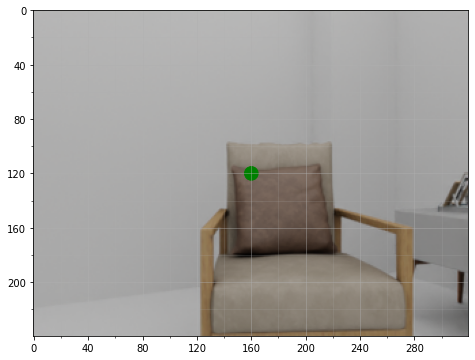

T_C2W diff:  tensor([[ 9.9849e-01, -5.5023e-02,  8.4290e-09,  3.2029e+01],
        [ 5.5023e-02,  9.9849e-01, -3.7357e-09,  2.1488e+01],
        [-8.2107e-09,  4.1937e-09,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
T_C2W vanila:  tensor([[-5.2074e-08, -5.5023e-02,  9.9849e-01,  2.5041e+01],
        [ 1.3306e-09,  9.9849e-01,  5.5023e-02,  1.4830e+02],
        [-1.0000e+00,  4.1937e-09, -5.1922e-08,  1.2700e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
t:  tensor([  0., 127., 127.], device='cuda:0')
t2:  tensor([ 1.1982e+02,  1.3380e+02, -6.0615e-06], device='cuda:0')
T_C2W right:  tensor([[-5.2074e-08, -5.5023e-02,  9.9849e-01,  2.4000e+01],
        [ 1.3306e-09,  9.9849e-01,  5.5023e-02,  1.2700e+02],
        [-1.0000e+00,  4.1937e-09, -5.1922e-08,  1.4290e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
T_C1W:  tensor([[[-4.3711e-08,  0.0000e+00

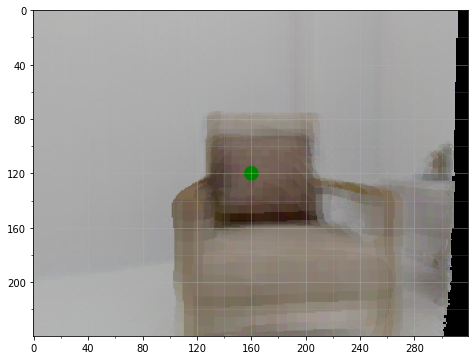

In [13]:
from PIL import Image
cam_poses2 = cam_poses[0].clone().to(device)[index].unsqueeze(0)

index=1
R0, t0 = look_at_view_transform(dist=-200, elev=0, azim=90)
t0 = torch.FloatTensor([[0.0,127.0,127.0]])
# Base Camera (original view) to Renderer World Transform
T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0)).to(device)
cam_poses2 = cam_poses[0].clone().to(device)[index].unsqueeze(0)
T_C1G = cam_poses[0][0].to(device)
offsets = (torch.FloatTensor([[0.0, -0.0, 0.0],[17.0,-0.0,21.0],[19.5,-0.0,11.7],]).to(device)*2.0)[index].unsqueeze(0) #[111.0,0.0,165.0]
offsets = [None, None, None]
scale = 10.0
input_dim = (254, 254, 254)
batch_size = 1
style_width = 320
style_height = 240
raycast_depth_max = 6.0
truncation = 1.5
ray_increment = 0.003 * truncation
thresh_sample_dist = 100.5 * ray_increment
max_num_locs_per_sample = 6400000
voxelsize = 0.0301
intrinsics = torch.FloatTensor([[277.1281435, 277.1281435, 160.0, 120.0]]).to(device)

raycaster = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize,
                                    thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)
from plot_image_grid import plot_image
import loss as loss_util

_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png')
plot_image(input_img)

view_matrices = []
permutations = [[0,1,2]]
signs = [[1,1,1]]
T_off = torch.FloatTensor([[1.0,0.0,0.0,22.5],[0.0,1.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]]).to(device)
for p in permutations:
    for sign in signs:
        T0 = T_C1G.clone()
        T0[:,0,-1] = T_C1G[:,p[0],-1]*sign[0]
        T0[:,1,-1] = T_C1G[:,p[1],-1]*sign[1]
        T0[:,2,-1] = T_C1G[:,p[2],-1]*sign[2]
        for T_C2G, offset in zip(cam_poses2, offsets):
            T1 = T_C2G.clone()
            T1[:,0,-1] = T_C2G[:,p[0],-1]*sign[0]
            T1[:,1,-1] = T_C2G[:,p[1],-1]*sign[1]
            T1[:,2,-1] = T_C2G[:,p[2],-1]*sign[2]
            # Compute the transformation from the camera pose of the aux view. to the Renderer World Frame
            # T_C2W = torch.matmul(torch.matmul(T1[0], torch.inverse(T0[0])), T_C1W[0])
            
            T_C2W = torch.matmul(T1[0], torch.inverse(T0[0]))
            print("T_C2W diff: ", T_C2W)
            T_C2W = torch.matmul((T_C2W), T_C1W[0])
            print("T_C2W vanila: ", T_C2W)
            # T_C2W[0,-1] *= -1
            # T_C2W[1,-1] *= 1
            # T_C2W[2,-1] *= 1
            print("t: ", T_C1W[0,:3,-1])
            print("t2: ", T_C2W[:3,:3]@T_C1W[0,:3,-1])
            # T_C2W[:3,-1] = torch.FloatTensor([6.9879, 127.0000, 126.8076]).to(device) + torch.FloatTensor([24.669,0.0,18.966]).to(device)
            # T_C2W[:3,-1] = T_C1W[0,:3,-1] + torch.FloatTensor([25.0,0.0,0.0]).to(device)
            T_C2W[:3,-1] = T_C1W[0,:3,-1] + torch.FloatTensor([24.0,0.0,15.9]).to(device)
            
            
            print("T_C2W right: ", T_C2W)
            print("T_C1W: ", T_C1W)
            
            
            # T_C2W = torch.matmul(torch.matmul(T1[0], torch.inverse(T0[0])), T_C1W[0])
            # T_C2W = torch.matmul(T_C1W[0], torch.matmul(T0[0], torch.inverse(T1[0])))
            T_C2W = torch.matmul(T_off, T_C2W)
            
            # Add offsets TODO: This should not be necessary
            if not offset is None:
                T_C2W[:3,-1] += offset
            # if not angle is None:
            #     T_C2W[:3,:3] = torch.matmul(rot_y(angle).to(device), T_C2W[:3,:3])
            T_C2W = T_C2W.unsqueeze(0)
            view_matrix = T_C2W

            view_matrix[:,:3,:3]/=voxelsize
            print(view_matrix.shape)
            target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
            raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
            raycast_color = torch.fliplr(raycast_color[0])
            print("sign: ", sign)
            print("permutation: ", p)
            plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
    


=====================CREATING RAYCAST RGBD MODEL=====================


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


view_matrix1:  tensor([[[ 3.2128e-14, -4.5475e-13,  1.0000e+00,  2.0000e+01],
         [-2.1760e-14,  1.0000e+00, -4.5475e-13,  1.2550e+02],
         [-1.0000e+00, -1.1635e-13, -5.9605e-08,  1.2550e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')


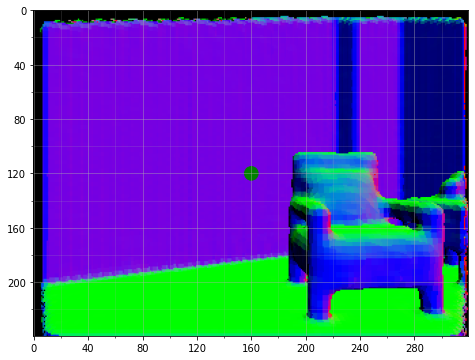

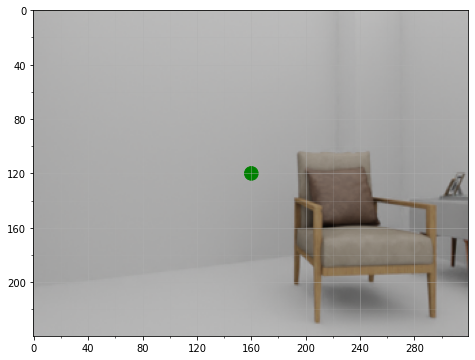

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


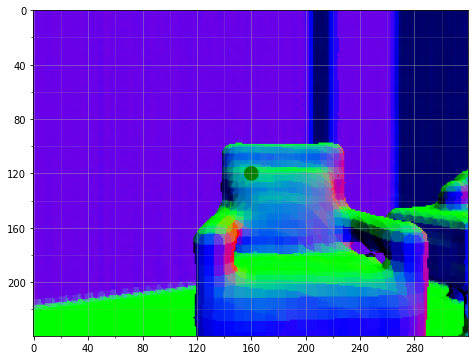

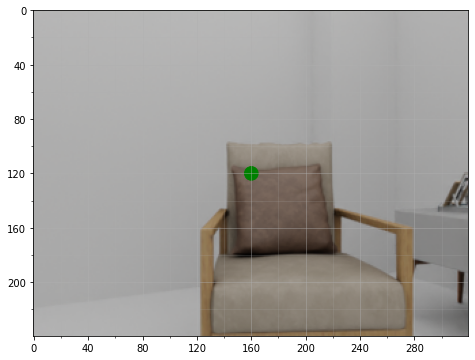

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


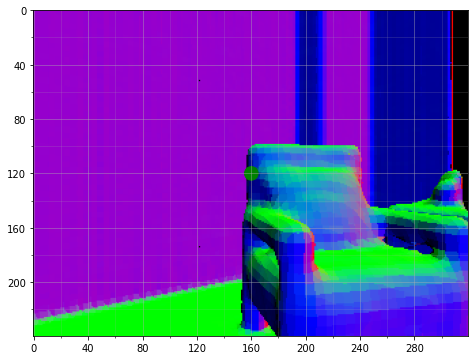

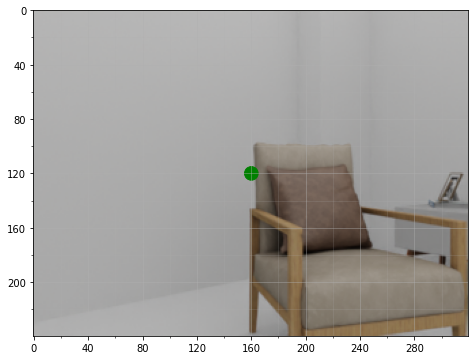

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


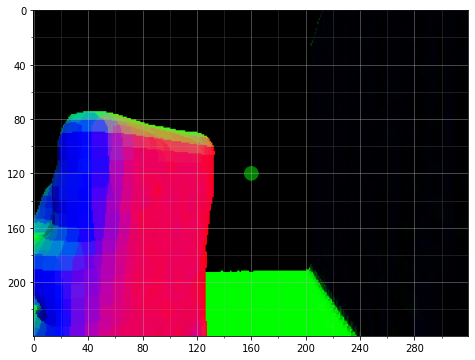

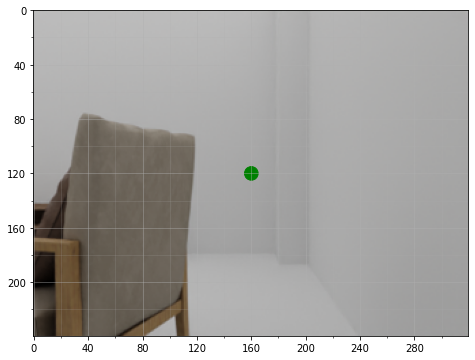

In [99]:
from PIL import Image
voxelsize = 0.03*256./254.

campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0021.npz')
T_pose4 = campose['blender_matrix']
T_pose4 = torch.FloatTensor(T_pose4).unsqueeze(0).to(device)
T_pose4[:,:3,-1] /= voxelsize

campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')
T_pose1 = campose['blender_matrix']
T_pose1 = torch.FloatTensor(T_pose1).unsqueeze(0).to(device)
T_pose1[:,:3,-1] /= voxelsize

campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')
T_pose2 = campose['blender_matrix']
T_pose2 = torch.FloatTensor(T_pose2).unsqueeze(0).to(device)
T_pose2[:,:3,-1] /= voxelsize

campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0018.npz')
T_pose3 = campose['blender_matrix']
T_pose3 = torch.FloatTensor(T_pose3).unsqueeze(0).to(device)
T_pose3[:,:3,-1] /= voxelsize
############################ 5 and 6 correspond to views from another chair ###############3333333
campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0023.npz')
T_pose5 = campose['blender_matrix']
T_pose5 = torch.FloatTensor(T_pose5).unsqueeze(0).to(device)
T_pose5[:,:3,-1] /= voxelsize

campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0025.npz')
T_pose6 = campose['blender_matrix']
T_pose6 = torch.FloatTensor(T_pose6).unsqueeze(0).to(device)
T_pose6[:,:3,-1] /= voxelsize

index=1
R0, t0 = look_at_view_transform(dist=-200, elev=0, azim=90)

################################################################################################################
# t0 = torch.FloatTensor([[20.5,125.5,125.0]])
t0 = torch.FloatTensor([[0.0,127.0,127.0]])

################################################################################################################

# Base Camera (original view) to Renderer World Transform
T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0)).to(device)
scale = 10.0
input_dim = (254, 254, 254)
batch_size = 1
style_width = 320
style_height = 240
raycast_depth_max = 6.0
truncation = 1.5
ray_increment = 0.003 * truncation
thresh_sample_dist = 100.5 * ray_increment
max_num_locs_per_sample = 6400000
intrinsics = torch.FloatTensor([[277.1281435, 277.1281435, 160.0, 120.0]]).to(device)

raycaster = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize,
                                    thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)
from plot_image_grid import plot_image
import loss as loss_util

_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

T_off = torch.FloatTensor([[1.0,0.0,0.0,1.5],[0.0,1.0,0.0,-1.5],[0.0,0.0,1.0,20.0],[0.0,0.0,0.0,1.0]]).to(device)



cam_poses2 = cam_poses.clone()

T_w2grid = (T_C1W[0]@torch.inverse(T_pose1[0])).unsqueeze(0) # TODO: try without inverse
view_matrix1 = (T_w2grid[0]@T_pose1[0]@T_off).unsqueeze(0)
print("view_matrix1: ",view_matrix1)

### Final FIX: Works
T_diff2 = torch.inverse(T_pose1[0])@T_pose2[0]
T_diff3 = torch.inverse(T_pose1[0])@T_pose3[0]
T_diff4 = torch.inverse(T_pose1[0])@T_pose4[0]
T_diff5 = torch.inverse(T_pose1[0])@T_pose5[0]
T_diff6 = torch.inverse(T_pose1[0])@T_pose6[0]


T_diff2[:3,-1] *= torch.FloatTensor([-1,0,-1]).to(device)
T_diff3[:3,-1] *= torch.FloatTensor([-1,0,-1]).to(device)
T_diff4[:3,-1] *= torch.FloatTensor([-1,0,-1]).to(device)
T_diff5[:3,-1] *= torch.FloatTensor([-1,0,-1]).to(device)
T_diff6[:3,-1] *= torch.FloatTensor([-1,0,-1]).to(device)


view_matrix2 = (view_matrix1[0]@T_diff2).unsqueeze(0)
view_matrix3 = (view_matrix1[0]@T_diff3).unsqueeze(0)
view_matrix4 = (view_matrix1[0]@T_diff4).unsqueeze(0)
view_matrix5 = (view_matrix1[0]@T_diff5).unsqueeze(0)
view_matrix6 = (view_matrix1[0]@T_diff6).unsqueeze(0)



view_matrix = view_matrix1.clone()
# view_matrix[0,:3,-1] += offset
target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
raycast_color = torch.fliplr(raycast_color[0])
raycast_normal = torch.fliplr(raycast_normal[0])
# plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
plot_image(raycast_normal.detach().cpu().numpy())
input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

view_matrix = view_matrix2.clone()
target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
raycast_color = torch.fliplr(raycast_color[0])
raycast_normal = torch.fliplr(raycast_normal[0])
# plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
plot_image(raycast_normal.detach().cpu().numpy())
input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png')
plot_image(input_img)

view_matrix = view_matrix3.clone()
target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
raycast_color = torch.fliplr(raycast_color[0])
raycast_normal = torch.fliplr(raycast_normal[0])

# plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
plot_image(raycast_normal.detach().cpu().numpy())

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0018.png')
plot_image(input_img)

view_matrix = view_matrix4.clone()
target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
raycast_color = torch.fliplr(raycast_color[0])
raycast_normal = torch.fliplr(raycast_normal[0])
# plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
plot_image(raycast_normal.detach().cpu().numpy())
input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0021.png')
plot_image(input_img)


In [19]:
#Revisit available data

campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0021.npz')
print(campose['camera2world'])
print(campose['blender_location'])
print(campose['blender_matrix'])
print(campose['intrinsic'])



print('\n keys:',campose.files)


[[ 1.42659619e-02  6.03513490e-06 -9.99898195e-01 -7.19755173e-01]
 [ 9.99898195e-01 -1.01067094e-07  1.42659619e-02  4.99090576e+00]
 [-1.49598005e-08 -1.00000000e+00 -6.03596209e-06  7.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-0.71975517  4.99090576  0.75      ]
[[ 1.42659619e-02 -6.03513490e-06  9.99898195e-01 -7.19755173e-01]
 [ 9.99898195e-01  1.01067094e-07 -1.42659619e-02  4.99090576e+00]
 [-1.49598005e-08  1.00000000e+00  6.03596209e-06  7.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[277.12811989   0.         160.        ]
 [  0.         311.76912635 120.        ]
 [  0.           0.           1.        ]]

 keys: ['camera2world', 'intrinsic', 'fov_x', 'fov_y', 'room_id', 'blender_matrix', 'blender_location', 'blender_rotation_euler']


# Convert geometry ground truth from TDF to TSDF

In [9]:
# geometry = targets[0].get_field("geometry").squeeze()
# print("geometry shape: ", geometry.shape)
# print("geometry range: [{},{}]".format(geometry.min(),geometry.max()))

In [14]:
# Read geometry from file
import numpy as np
distance_field = np.load("data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/geometry_0001.npz")["data"]
print("geometry shape: ", distance_field.shape)
print("geometry range: [{},{}]".format(distance_field.min(),distance_field.max()))

geometry shape:  (256, 256, 256)
geometry range: [0.00016082213551271707,12.0]


## TDF to Mesh (non differentiable operation) using Marching Cubes

In [15]:
import lib.visualize as vis

if isinstance(geometry, torch.Tensor):
    distance_field = geometry.detach().cpu().numpy()

vertices, triangles = vis.get_mesh(distance_field, iso_value=1.0, truncation=12.0)
print("vertices shape: ", vertices.shape)
print("vertices range: [{},{}]".format(vertices.min(),vertices.max()))
print(triangles.shape)

vertices shape:  (42926, 3)
vertices range: [68.43592832405767,180.0131896696613]
(85868, 3)


## Mesh to TSDF

In [17]:
import trimesh
import mesh2sdf
import time

size = 256
level = 1 / size
mesh_scale = 1.0
### 
# bbmin = vertices.min(0)
# bbmax = vertices.max(0)
bbmin = np.array([0.0,0.0,0.0])
bbmax = np.array([255.0,255.0,255.0])
center = (bbmin + bbmax) * 0.5
scale = 2.0 * mesh_scale / (bbmax - bbmin).max()
vertices = (vertices-center) * scale
print("vertices range: [{},{}]".format(vertices.min(),vertices.max()))

###

t0 = time.time()
sdf_orig, mesh = mesh2sdf.compute(
    vertices, triangles, size, fix=True, level=level, return_mesh=True)
t1 = time.time()

# # # output
# mesh.vertices = mesh.vertices / scale + center

vertices range: [-0.463247620987783,0.41186815427185336]


In [18]:
print('It takes %.4f seconds to process' % (t1-t0))
print("sdf shape: ", sdf_orig.shape)
print("sdf range: [{},{}]".format(sdf_orig.min(),sdf_orig.max()))
print("mesh.vertices shape: ", mesh.vertices.shape)
print("mesh.vertices range: [{},{}]".format(mesh.vertices.min(),mesh.vertices.max()))
print(scale)

It takes 173.1550 seconds to process
sdf shape:  (256, 256, 256)
sdf range: [-0.019525444135069847,1.5412657260894775]
mesh.vertices shape:  (84533, 3)
mesh.vertices range: [-0.46536242961883545,0.4143359661102295]
0.00784313725490196


In [20]:
## Save
sdf_save = sdf_orig/scale

print("sdf_save shape: ", sdf_save.shape)
print("sdf_save range: [{},{}]".format(sdf_save.min(),sdf_save.max()))
sdf_save = np.clip(sdf_save, -12.0, 12.0)

np.savez("data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/geometry_sdf_0001.npz", sdf_save)
del sdf_save

sdf_save shape:  (256, 256, 256)
sdf_save range: [-2.4894940853118896,196.51136779785156]


In [188]:
# Get Dense Color Predictions
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
# geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
# semantics, _, _ = semantics_sparse.dense(dense_dimensions, min_coordinates)


rgb = rgb.squeeze()
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))


rgb: torch.Size([3, 256, 256, 256])
rgb values: [1.948082685470581,-2.1027653217315674]


In [189]:
# Render using spsg
truncation = 3.0
from torch.nn import functional as F

from pytorch3d.renderer import (
    look_at_view_transform,
)
from torch.nn import functional as F
def homogeneous_transform(R,t):
    last_row = torch.FloatTensor([[0,0,0,1]]).unsqueeze(0)
    T = torch.cat((R,t),dim=2)
    return torch.cat((T,last_row),dim=1)

sdf = torch.FloatTensor(sdf_orig/scale).to(device)
print("colors shape: ", rgb.shape)
print("sdf shape: ", sdf.shape)
print("sdf range: [{},{}]".format(sdf.min(),sdf.max()))

rgb = (F.interpolate(rgb.unsqueeze(0), size=(254,254,254), mode="trilinear", align_corners=True))[0]
sdf = (F.interpolate(sdf.unsqueeze(0).unsqueeze(0), size=(254,254,254), mode="trilinear", align_corners=True))[0,0]

sdf = sdf.unsqueeze(0).unsqueeze(0)
colors = rgb.permute(1,2,3,0).unsqueeze(0)
# Obtain sparse tensor of sdf, colors and semantic weights
locs = torch.nonzero(torch.abs(sdf[:,0]) < truncation)
locs = torch.cat([locs[:,1:], locs[:,:1]],1).contiguous()
vals = sdf[locs[:,-1],:,locs[:,0],locs[:,1],locs[:,2]].contiguous()
colors = colors[locs[:,-1],locs[:,0],locs[:,1],locs[:,2],:].float() #/255.0
print(locs.shape)
print("locs range: [{},{}]".format(locs.min(),locs.max()))

print(truncation)

colors shape:  torch.Size([3, 256, 256, 256])
sdf shape:  torch.Size([255, 255, 255])
sdf range: [-6.841657638549805,196.45570373535156]
torch.Size([154177, 4])
locs range: [0,189]
3.0


In [190]:
sys.path.append('/usr/src/app/spsg/torch')
from utils.raycast_rgbd.raycast_rgbd import RaycastRGBD
import loss as loss_util

truncation = 3.0
device = torch.device(config.MODEL.DEVICE)
input_dim = (254, 254, 254)
batch_size = 1
style_width = 320
style_height = 240
raycast_depth_max = 6.0
ray_increment = 0.003 * truncation
thresh_sample_dist = 100.5 * ray_increment
max_num_locs_per_sample = 640000
num_views = 3
voxelsize = 0.0301

=====================CREATING RAYCAST RGBD MODEL=====================
tensor([[[-4.3711e-08,  0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00, -4.3711e-08]]])


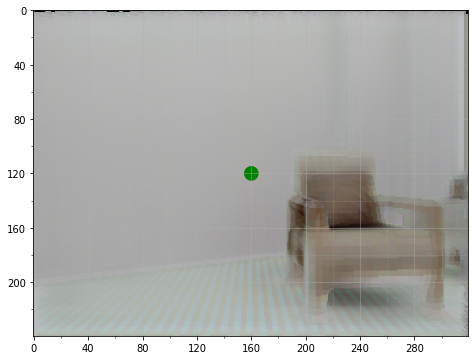

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


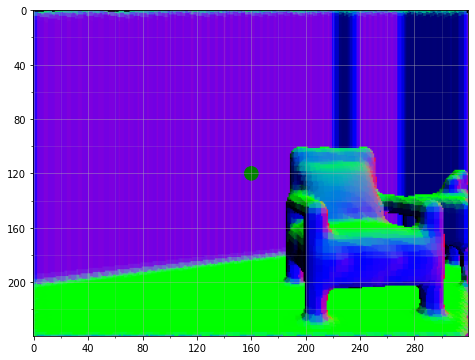

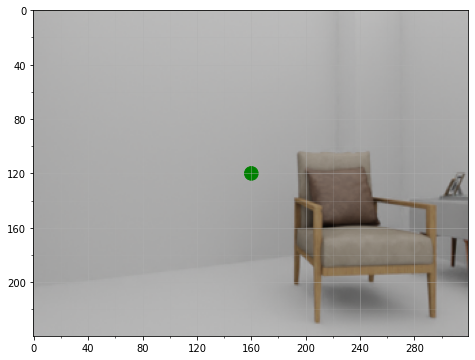

In [268]:
mult=1.0
# 311.76912635
intrinsics = torch.FloatTensor([[277.1281435*mult, 277.1281435*mult, 160.0, 120.0]]).to(device)
raycaster_rgbd = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize, 
                                    thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)

from plot_image_grid import plot_image
from PIL import Image
R0, t0 = look_at_view_transform(dist=-200, elev=0, azim=90)
t0 = torch.FloatTensor([[22.5,127.0,127.0]])
# R0, t0 = look_at_view_transform(eye= torch.FloatTensor([1.0,-1.0,-128.0]).unsqueeze(0), at=((-100, -200, 128), ), up=((0, 1, 0), ))
print(R0)
# Base Camera (original view) to Renderer World Transform
T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0)).to(device)
view_matrix = T_C1W
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster_rgbd(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
raycast_color = torch.fliplr(raycast_color[0])
raycast_normal = torch.fliplr(raycast_normal[0])

plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
plot_image(raycast_normal.detach().cpu().numpy())

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

## Render other views

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


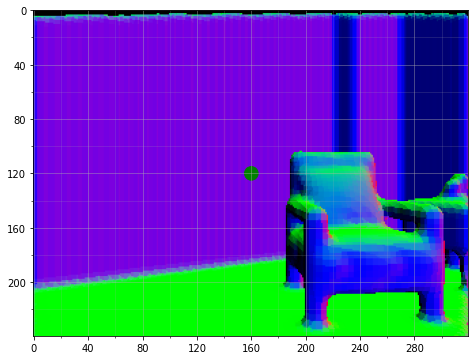

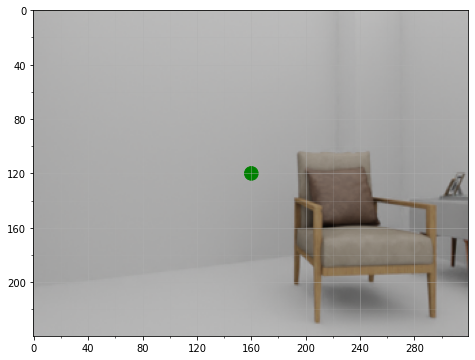

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


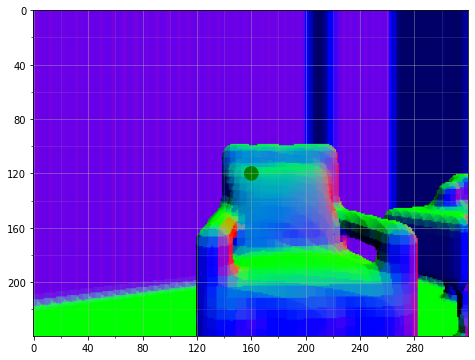

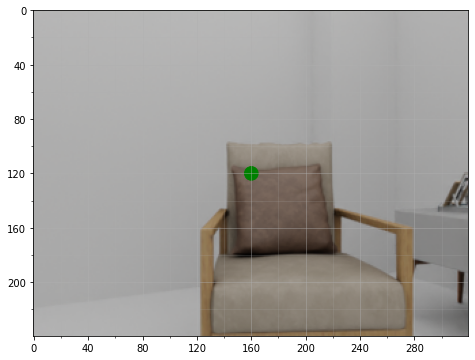

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


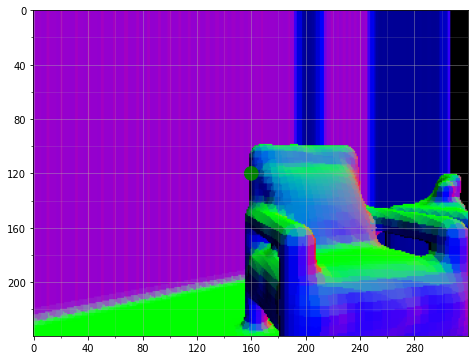

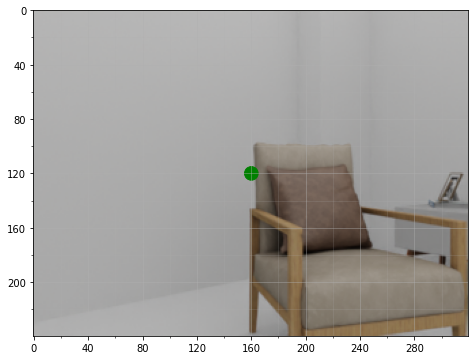

In [269]:
T_GC1 = cam_poses[0][0].to(device)
img_paths = ['data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png',
                'data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png',
                'data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0018.png']
offsets = torch.FloatTensor([[0.0, -0.5, 0.0],[17.0,-0.5,21.5],[19.5,-0.5,11.7],]).to(device)*2.0 #[111.0,0.0,165.0]

for T_GC2, img_path, offset in zip(cam_poses[0], img_paths, offsets):
    T_GC2 = T_GC2.to(device)
    T_C2W = torch.matmul(torch.matmul(torch.inverse(T_GC2[0]), T_GC1[0]), T_C1W[0])
    T_C2W[:3,-1] += offset
    T_C2W = T_C2W.unsqueeze(0)
    view_matrix = T_C2W.clone()
    
    target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
    raycast_color, _, raycast_normal = raycaster_rgbd(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
    raycast_color = torch.fliplr(raycast_color[0])
    raycast_normal = torch.fliplr(raycast_normal[0])

    # plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
    plot_image(raycast_normal.detach().cpu().numpy())
    
    input_img = Image.open(img_path)
    plot_image(input_img)

# Pytorch3D volume rendering

In [57]:
# Get Dense Color Predictions
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
# semantics, _, _ = semantics_sparse.dense(dense_dimensions, min_coordinates)


rgb = rgb.squeeze()
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))

print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))
# geometry-=1.5

rgb: torch.Size([3, 256, 256, 256])
rgb values: [2.59527325630188,-1.736430287361145]
geometry: torch.Size([1, 1, 256, 256, 256])
geometry values: [3.0,0.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 256, 256, 256, 3])
x: [-3.8249998092651367.3.8249998092651367]
tensor([[256, 256, 256]], device='cuda:0')


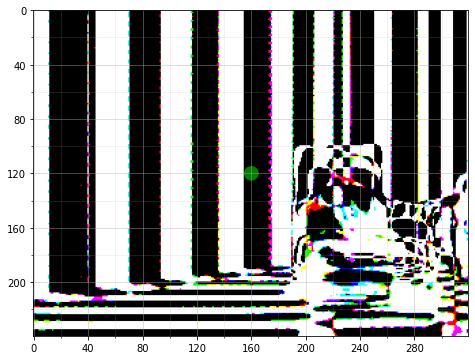

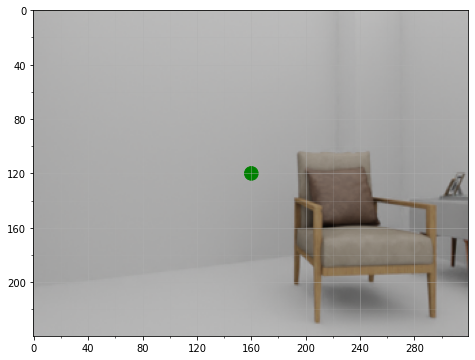

In [67]:
## Volume Rendering
from pytorch3d.structures import Volumes
from plot_image_grid import plot_image
from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PerspectiveCameras,
    OrthographicCameras,
    VolumeRenderer,
    NDCGridRaysampler,
    MonteCarloRaysampler,
    GridRaysampler,
    EmissionAbsorptionRaymarcher,
    AbsorptionOnlyRaymarcher,
    NDCMultinomialRaysampler,
    MultinomialRaysampler
)
color_image_size = (240, 320)
FOCAL_LENGTH1 = 277.1281435
FOCAL_LENGTH2 = 311.76912635
# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

volume_extent_world = 10.0
height, width = color_image_size
raysampler = NDCMultinomialRaysampler(
    image_width=width,
    image_height=height,
    n_pts_per_ray=100,
    # min_x = -3,
    # min_y = -3,
    # max_x = 3,
    # max_y = 3,
    min_depth = 0.1,
    max_depth = 10.0,
)
    

raymarcher = EmissionAbsorptionRaymarcher()

renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher
)

image_size = torch.Tensor([height, width]).unsqueeze(0)


R, T = look_at_view_transform(eye= torch.FloatTensor([-3.0,0.0,0.0]).unsqueeze(0), at=((0, 0, 0), ), up=((0, -1, 0), ))


cameras = PerspectiveCameras(device=device, R=R, T=T, focal_length=((FOCAL_LENGTH1,FOCAL_LENGTH2),),
                             principal_point=(([160,120]),), image_size=((240, 320), ),in_ndc=False) #, K=front3d_intrinsic.unsqueeze(0))\

# cameras = PerspectiveCameras(device=device, R=R0, T=t0) #, K=front3d_intrinsic.unsqueeze(0))\

volume = Volumes(
    densities = geometry,
    features = rgb.unsqueeze(0),
    voxel_size = 0.03,
    volume_translation = torch.FloatTensor([0.0,0.0,0.0])
).to(device)

images = renderer(cameras=cameras, volumes=volume)

grid = volume.get_coord_grid()
print(grid.shape)
print("x: [{}.{}]".format(torch.min(grid), torch.max(grid)))
print(volume.get_grid_sizes())
image = images[0][0, ..., :3].cpu().detach().numpy()
plot_image(np.flip(image,axis=1))


from PIL import Image

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173040


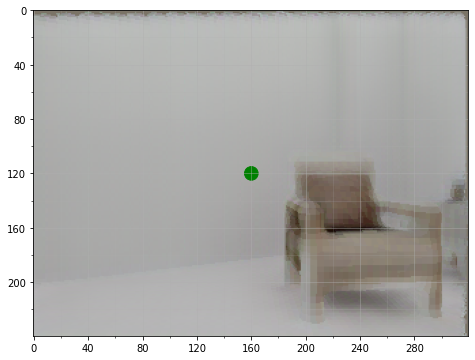

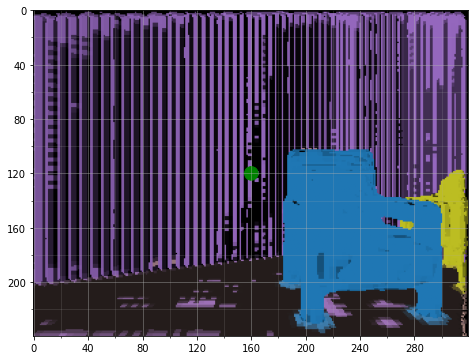

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


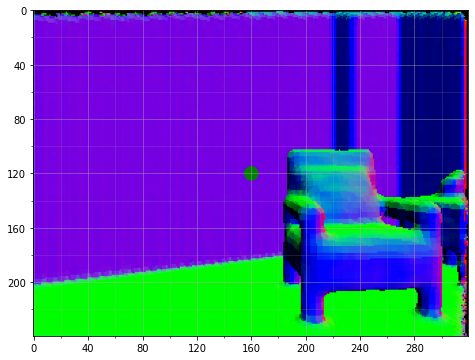

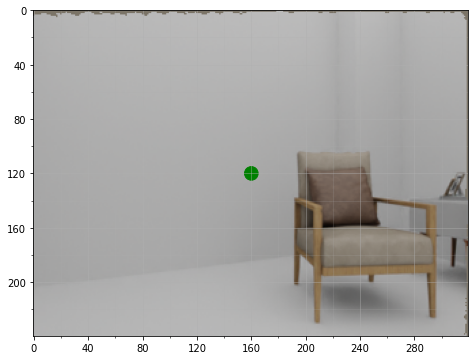

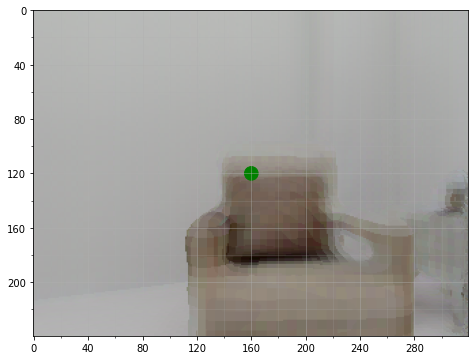

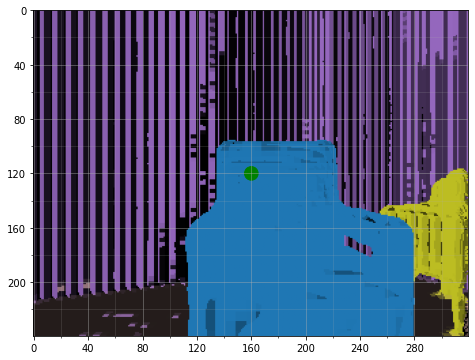

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


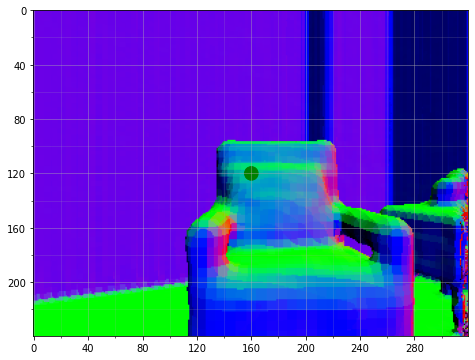

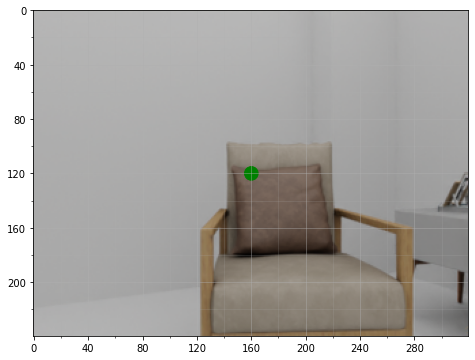

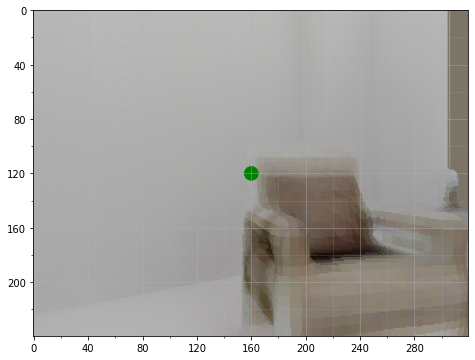

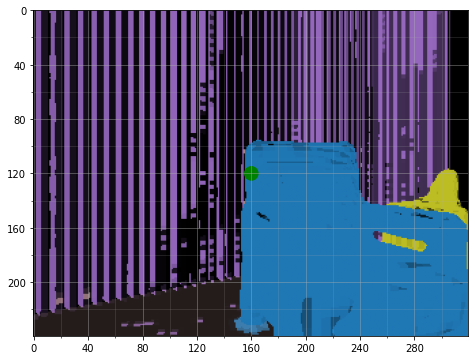

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


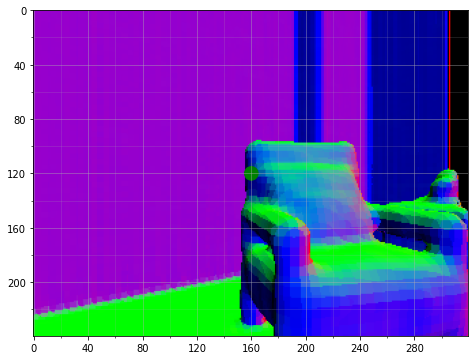

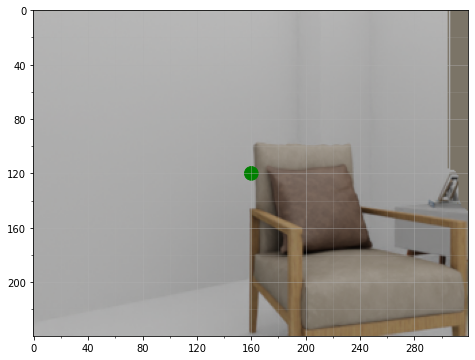

Total loss:  tensor(1.9579, device='cuda:0', grad_fn=<AddBackward0>)
L1 loss:  tensor(0.1010, device='cuda:0', grad_fn=<DivBackward0>)
style loss:  tensor(0.8251, device='cuda:0', grad_fn=<AddBackward0>)
loss_content:  tensor(217.9550, device='cuda:0', grad_fn=<AddBackward0>)
disc_loss:  tensor(1.3873, device='cuda:0', grad_fn=<AddBackward0>)
gen_loss:  tensor(0.7058, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [272]:
from lib.modeling.frustum.rgb_loss import RGBLoss
from plot_image_grid import plot_image
cam_poses2 = cam_poses.clone()
cam_poses2[:,:,:,:3,-1] *= 0.0301

rgb_loss = RGBLoss()
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, semantic_sparse_prediction, aux_views, cam_poses2.to(device), debug=True)

In [ ]:
# from PIL import Image
# cam_poses2 = cam_poses[0].clone().to(device)[index].unsqueeze(0)
# voxelsize = 0.0301

# campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0021.npz')
# T_pose4 = campose['blender_matrix']
# T_pose4 = torch.FloatTensor(T_pose4).unsqueeze(0).to(device)
# T_pose4[:,:3,-1] /= voxelsize

# campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')
# T_pose1 = campose['blender_matrix']
# T_pose1 = torch.FloatTensor(T_pose1).unsqueeze(0).to(device)
# T_pose1[:,:3,-1] /= voxelsize

# campose = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')
# T_pose2 = campose['blender_matrix']
# T_pose2 = torch.FloatTensor(T_pose2).unsqueeze(0).to(device)
# T_pose2[:,:3,-1] /= voxelsize

# index=1
# R0, t0 = look_at_view_transform(dist=-200, elev=0, azim=90)
# t0 = torch.FloatTensor([[0.0,127.0,127.0]])
# # Base Camera (original view) to Renderer World Transform
# T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0)).to(device)
# cam_poses2 = cam_poses[0].clone().to(device)[index].unsqueeze(0)
# offsets = (torch.FloatTensor([[0.0, -0.0, 0.0],[17.0,-0.0,21.0],[19.5,-0.0,11.7],]).to(device)*2.0)[index].unsqueeze(0) #[111.0,0.0,165.0]
# offsets = [None, None, None]
# scale = 10.0
# input_dim = (254, 254, 254)
# batch_size = 1
# style_width = 320
# style_height = 240
# raycast_depth_max = 6.0
# truncation = 1.5
# ray_increment = 0.003 * truncation
# thresh_sample_dist = 100.5 * ray_increment
# max_num_locs_per_sample = 6400000
# intrinsics = torch.FloatTensor([[277.1281435, 277.1281435, 160.0, 120.0]]).to(device)

# raycaster = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize,
#                                     thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)
# from plot_image_grid import plot_image
# import loss as loss_util

# _imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
# T_off = torch.FloatTensor([[1.0,0.0,0.0,0.0],[0.0,1.0,0.0,0.0],[0.0,0.0,1.0,22.5],[0.0,0.0,0.0,1.0]]).to(device)


# cam_poses2 = cam_poses.clone()
# # cam_poses2[:,:,:,:3,-1] /= 0.0301

# # T_pose1 = cam_poses2[0][0].to(device)
# # T_pose2 = cam_poses2[0][1].to(device)
# T_pose3 = cam_poses2[0][2].to(device)

# # T_pose1[0] = torch.inverse(T_pose1[0])
# # T_pose4[0] = torch.inverse(T_pose4[0])

# view_matrix1 = T_C1W.clone()
# # print("view_matrix1: ",T_C1W)
# # print("T_pose1: ",T_pose1)
# T_w2grid = (view_matrix1[0]@torch.inverse(T_pose1[0])).unsqueeze(0) # TODO: try without inverse
# # print("T_w2grid: ", T_w2grid)

# view_matrix1 = (T_w2grid[0]@T_pose1[0]@T_off).unsqueeze(0)
# view_matrix2 = (T_w2grid[0]@T_pose2[0]@T_off).unsqueeze(0)
# view_matrix3 = (T_w2grid[0]@T_pose3[0]@T_off).unsqueeze(0)
# view_matrix4 = (T_w2grid[0]@T_pose4[0]@T_off).unsqueeze(0)


# print("view_matrix1: ",view_matrix1)
# print("view_matrix2: ",view_matrix2)
# # print("view_matrix3: ",view_matrix3)
# print("view_matrix4: ",view_matrix4)

# # offsets
# # view_matrix2[0,2,-1] += 17.58*2
# # view_matrix4[0,0,-1] += 24
# # view_matrix4[0,2,-1] += 102
# # view_matrix4[0,:3,:3] = rot_y(3.14+0.92).to(device) @ view_matrix4[0,:3,:3]

# # With blender_matrix
# view_matrix2_0 = view_matrix2.clone()
# view_matrix4_0 = view_matrix4.clone()

# view_matrix2[0,:3,-1] += torch.FloatTensor([50.,0.,35.]).to(device)
# view_matrix4[0,:3,-1] += torch.FloatTensor([256.947,0.,120.28]).to(device)
# view_matrix4[0,:3,:3] = rot_y(0.0).to(device) @ view_matrix4[0,:3,:3]

# T_diff2 = torch.inverse(T_pose1[0])@T_pose2[0]
# T_diff4 = torch.inverse(T_pose1[0])@T_pose4[0]

# T_real2 = torch.inverse(view_matrix1[0])@view_matrix2[0]
# T_real4 = torch.inverse(view_matrix1[0])@view_matrix4[0]

# print("\nT_diff2: ", T_diff2)
# print("T_real2: ", T_real2)
# print("T_diff4: ", T_diff4)
# print("T_real4: ", T_real4)


# ### Final FIX: Works
# T_diff2 = torch.inverse(T_pose1[0])@T_pose2[0]
# T_diff4 = torch.inverse(T_pose1[0])@T_pose4[0]

# T_diff2[:3,-1] *= torch.FloatTensor([-1,0,-1]).to(device)
# T_diff4[:3,-1] *= torch.FloatTensor([-1,0,-1]).to(device)
# view_matrix1 = (T_w2grid[0]@T_pose1[0]@T_off).unsqueeze(0)

# view_matrix2 = (view_matrix1[0]@T_diff2).unsqueeze(0)
# view_matrix4 = (view_matrix1[0]@T_diff4).unsqueeze(0)



# # view_matrix1 = (T_w2grid[0]@T_pose1[0]@T_off).unsqueeze(0)
# # view_matrix2 = (T_w2grid[0]@T_pose2[0]@T_off).unsqueeze(0)
# # view_matrix3 = (T_w2grid[0]@T_pose3[0]@T_off).unsqueeze(0)
# # view_matrix4 = (T_w2grid[0]@T_pose4[0]@T_off).unsqueeze(0)



# print("\nview_matrix2: ",view_matrix2)

# print("view_matrix4: ",view_matrix4)

# view_matrix = view_matrix1.clone()
# # view_matrix[0,:3,-1] += offset
# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
# raycast_color = torch.fliplr(raycast_color[0])
# plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
# plot_image(input_img)

# view_matrix = view_matrix2.clone()

# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
# raycast_color = torch.fliplr(raycast_color[0])
# plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png')
# plot_image(input_img)

# view_matrix = view_matrix4.clone()
# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
# raycast_color = torch.fliplr(raycast_color[0])
# plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0021.png')
# plot_image(input_img)
